In [24]:
import coremltools

keras_model_path = 'mtcnn/mtcnn_onet.h5'
tf_model_path = 'mtcnn/mtcnn_onet.h5.pb'

# explore tf model
import tensorflow as tf
tf_graph = tf.Graph()
tf_graphdef = tf.GraphDef()
with open(tf_model_path, "rb") as f:
    tf_graphdef.ParseFromString(f.read())
with tf_graph.as_default():
    tf.import_graph_def(tf_graphdef)

# keras PreLU not fully supported by coremltools
# coreml_model = coremltools.converters.keras.convert('mtcnn/mtcnn_onet.h5')

# use tf-coreml converter
import tfcoreml as tf_converter
# One thing to note, I have 
tf_converter.convert(tf_model_path = tf_model_path,
                     mlmodel_path = 'mtcnn/mtcnn_onet_h5_pb.mlmodel',
                     output_feature_names = ['output_node0:0', 'output_node1:0', 'output_node2:0'],
                     input_name_shape_dict = {'input_1:0' : [1, 48, 48, 3]})					

Shapes not found for 51 tensors. Executing graph to determine shapes. 
Automatic shape interpretation succeeded for input blob input_1:0
1/108: Analysing op name: conv6-3/bias ( type:  Const )
2/108: Analysing op name: conv6-3/bias/read ( type:  Identity )
3/108: Analysing op name: conv6-3/kernel ( type:  Const )
4/108: Analysing op name: conv6-3/kernel/read ( type:  Identity )
5/108: Analysing op name: conv6-2/bias ( type:  Const )
6/108: Analysing op name: conv6-2/bias/read ( type:  Identity )
7/108: Analysing op name: conv6-2/kernel ( type:  Const )
8/108: Analysing op name: conv6-2/kernel/read ( type:  Identity )
9/108: Analysing op name: conv6-1/bias ( type:  Const )
10/108: Analysing op name: conv6-1/bias/read ( type:  Identity )
11/108: Analysing op name: conv6-1/kernel ( type:  Const )
12/108: Analysing op name: conv6-1/kernel/read ( type:  Identity )
13/108: Analysing op name: prelu5/alpha ( type:  Const )
14/108: Analysing op name: prelu5/alpha/read ( type:  Identity )
15/108

input {
  name: "input_1__0"
  type {
    multiArrayType {
      shape: 3
      shape: 48
      shape: 48
      dataType: DOUBLE
    }
  }
}
output {
  name: "output_node2__0"
  type {
    multiArrayType {
      shape: 10
      dataType: DOUBLE
    }
  }
}
output {
  name: "output_node1__0"
  type {
    multiArrayType {
      shape: 4
      dataType: DOUBLE
    }
  }
}
output {
  name: "output_node0__0"
  type {
    multiArrayType {
      shape: 2
      dataType: DOUBLE
    }
  }
}

one frame of tf took 45.70 ms
tf output:  0.94714165 [ 0.16770038  0.02955749 -0.15893562 -0.04544077] [0.37552634 0.68758816 0.5525363  0.38927683 0.6717414  0.39385542
 0.3886004  0.53696185 0.72295165 0.71347237]


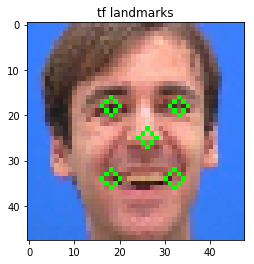

one frame of coreml took 6.00 ms
coreml output:  0.9471414089202881 [ 0.16769949  0.02955724 -0.1589351  -0.04544082] [0.37552628 0.68758833 0.55253649 0.38927719 0.67174149 0.39385524
 0.38860017 0.53696173 0.72295159 0.71347255]


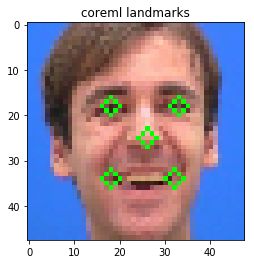

one frame of tf took 2.02 ms
tf output:  0.9990226 [ 0.05837984 -0.00450897 -0.14992392  0.00686981] [0.2775753  0.6406891  0.45905274 0.3119001  0.64288753 0.33718053
 0.31931305 0.48876464 0.7101515  0.69875497]


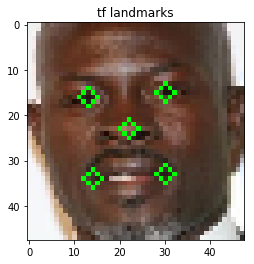

one frame of coreml took 1.52 ms
coreml output:  0.9990226030349731 [ 0.05837964 -0.00450991 -0.14992353  0.00686917] [0.27757514 0.64068907 0.45905229 0.31189978 0.64288729 0.33717972
 0.31931242 0.488765   0.71015131 0.69875503]


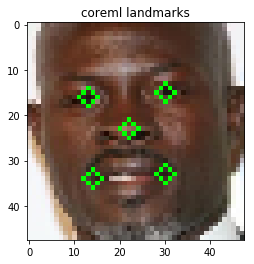

In [25]:
%matplotlib inline
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

input_op = tf_graph.get_operation_by_name('import/input_1')
output_ops = [tf_graph.get_operation_by_name(name) for name in ['import/output_node0', 'import/output_node1', 'import/output_node2']]

filenames = ['face1.jpg', 'face2.jpg']
images_tf = []
images_coreml = []
norm_images = []
tf_inputs = []
for f in filenames:
    image = cv2.imread(f)
    images_tf.append(cv2.resize(image, (48, 48)))
    images_coreml.append(cv2.resize(image, (48, 48)))
    norm_images.append((cv2.resize(image, (48, 48))-127.5)/127.5)
    tf_inputs.append(np.expand_dims(norm_images[-1], 0))

# model setup
sess = tf.Session(graph = tf_graph)
coreml_model = coremltools.models.MLModel('mtcnn/mtcnn_onet_h5_pb.mlmodel')

# runtime
for fi in range(len(filenames)):
    start = time.time()
    inference_output = sess.run([o.outputs[0] for o in output_ops], {input_op.outputs[0]: tf_inputs[fi]})
    print('one frame of tf took {:.02f} ms'.format((time.time()-start)*1e3))
    face_prob = inference_output[0][0][1]
    roi_raw = inference_output[1][0]
    landmarks_raw = inference_output[2][0]
    print('tf output: ', face_prob, roi_raw, landmarks_raw)
    landmarks = [] 
    for i in range(5):
        landmarks.append((landmarks_raw[i]*48, landmarks_raw[i+5]*48))
        cv2.circle(images_tf[fi], (int(landmarks[i][0]), int(landmarks[i][1])), 2, (0, 255, 0))
    image = cv2.cvtColor(images_tf[fi], cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title('tf landmarks')
    plt.show()

    coreml_inputs = {'input_1__0': np.moveaxis(norm_images[fi], -1, 0)}
    start = time.time()
    coreml_output = coreml_model.predict(coreml_inputs, useCPUOnly=True)
    print('one frame of coreml took {:.02f} ms'.format((time.time()-start)*1e3))
    face_prob = coreml_output['output_node0__0'][1]
    roi_raw = coreml_output['output_node1__0']
    landmarks_raw = coreml_output['output_node2__0']
    print('coreml output: ', face_prob, roi_raw, landmarks_raw)
    landmarks = [] 
    for i in range(5):
        landmarks.append((landmarks_raw[i]*48, landmarks_raw[i+5]*48))
        cv2.circle(images_coreml[fi], (int(landmarks[i][0]), int(landmarks[i][1])), 2, (0, 255, 0))
    image = cv2.cvtColor(images_coreml[fi], cv2.COLOR_BGR2RGB)
    plt.title('coreml landmarks')
    plt.imshow(image)
    plt.show()

In [22]:
tf_graph.get_operations()

[<tf.Operation 'import/input_1' type=Placeholder>,
 <tf.Operation 'import/conv1/kernel' type=Const>,
 <tf.Operation 'import/conv1/kernel/read' type=Identity>,
 <tf.Operation 'import/conv1/bias' type=Const>,
 <tf.Operation 'import/conv1/bias/read' type=Identity>,
 <tf.Operation 'import/conv1/convolution' type=Conv2D>,
 <tf.Operation 'import/conv1/BiasAdd' type=BiasAdd>,
 <tf.Operation 'import/prelu1/alpha' type=Const>,
 <tf.Operation 'import/prelu1/alpha/read' type=Identity>,
 <tf.Operation 'import/prelu1/Relu' type=Relu>,
 <tf.Operation 'import/prelu1/Neg' type=Neg>,
 <tf.Operation 'import/prelu1/Neg_1' type=Neg>,
 <tf.Operation 'import/prelu1/Relu_1' type=Relu>,
 <tf.Operation 'import/prelu1/mul' type=Mul>,
 <tf.Operation 'import/prelu1/add' type=Add>,
 <tf.Operation 'import/max_pooling2d_1/MaxPool' type=MaxPool>,
 <tf.Operation 'import/conv2/kernel' type=Const>,
 <tf.Operation 'import/conv2/kernel/read' type=Identity>,
 <tf.Operation 'import/conv2/bias' type=Const>,
 <tf.Operation 'i